In [13]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [14]:
era5_train = pd.read_csv("train.csv", sep=",")
era5_train, era5_validation = train_test_split(era5_train, test_size=0.2, random_state=42)
#era5_test = pd.read_csv("test.csv", sep=",")

In [15]:
def calcDistance(row, reference_point):
    point = (row['latitude'], row['longitude'])
    return geodesic(point, reference_point).kilometers

def calcBearing(row, reference_point):
    lat1, lon1 = np.radians(reference_point)  # Reference point (convert to radians)
    lat2, lon2 = np.radians((row['latitude'], row['longitude']))  # Data point (convert to radians)

    lon_diff = lon2 - lon1  # Difference in longitudes

    # Calculating bearing
    x = np.sin(lon_diff) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_diff)

    # Convert bearing from radians to degrees
    bearing = np.degrees(np.arctan2(x, y))

    return (bearing + 360) % 360 # Return normalised bearing in range [0, 360]

In [16]:
# Calculate the central point (mean latitude and mean longitude)
central_latitude = era5_train['latitude'].mean()
central_longitude = era5_train['longitude'].mean()

# Print the central point (latitude, longitude)
print(f"Central Latitude: {central_latitude}")
print(f"Central Longitude: {central_longitude}")

central_point = (central_latitude, central_longitude)

Central Latitude: 54.50017150095719
Central Longitude: -2.999218404317281


In [17]:
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] & 12 + 3) // 3) + 1
    return data

def prepareData(data, reference_point):
    data.drop(["id"], axis = 1, inplace = True) # Removing id

    data["valid_time"] = pd.to_datetime(data["valid_time"]) # Convert valid_time to suitable format
    data = convertDateTimeToComponents(data, "valid_time")  # Create columns from valid_time
    data.drop(["valid_time"], axis = 1, inplace = True) # Removing valid_time

    data["distance_to_center"] = data.apply(calcDistance, axis=1, reference_point=reference_point) # Calculating distance from points to center point
    data["bearing_to_center"] = data.apply(calcBearing, axis=1, reference_point=reference_point) # Calculating point bearing from center point

    
prepareData(era5_train, central_point)
prepareData(era5_validation, central_point)

In [20]:
# Save the prepared datasets to CSV files
era5_train.to_csv('prepared_era5_train.csv', index=False)
era5_validation.to_csv('prepared_era5_validation.csv', index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


In [18]:
attributes = list(era5_train.columns)
one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))
print(one_hot_attributes)
print(numerical_attributes)

['year', 'month', 'day', 'hour', 'season', 'ptype']
['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc', 'distance_to_center', 'bearing_to_center']


In [21]:
def encodeData(data, one_hot_attributes, numerical_attributes):
    x = data.drop("t2m", axis=1)
    y = data["t2m"]

    onehot_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder())
    ])

    # Defining pipeline for numerical scaling
    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    transformers = [
        ("cat-onehot", onehot_pipeline, one_hot_attributes),
        ("numerical", numerical_pipeline, numerical_attributes)
    ]

    full_pipeline = ColumnTransformer(transformers=transformers)
    x_prepared = full_pipeline.fit_transform(x)
    return x_prepared, y

x_train, y_train = encodeData(era5_train, one_hot_attributes, numerical_attributes)
x_validation, y_validation = encodeData(era5_validation, one_hot_attributes, numerical_attributes)

In [27]:
best_params_lr = {"copy_X": True,
                  "fit_intercept": True,
                  "n_jobs": 1,
                  "positive": False}

In [30]:
if best_params_lr == {}:
    model = LinearRegression()

    param_grid = {'copy_X': [True,False],
              'fit_intercept': [True,False],
              'n_jobs': [1,5,10,15,None],
              'positive': [True,False]}

    grid_search = GridSearchCV(model, param_grid, cv=5)

    grid_search.fit(x_train, y_train)

    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")

    best_linear_regression = grid_search.best_estimator_
else:
    best_linear_regression = LinearRegression(**best_params_lr)
    best_linear_regression.fit(x_train, y_train)
    print("Best parameters already found:", best_params_lr)

Best parameters already found: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}


In [32]:
y_validation_pred = best_linear_regression.predict(x_validation)

In [33]:
# Compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_validation, y_validation_pred))
print(f"Validation RMSE: {round(rmse, 4)}")

Validation RMSE: 2.3846


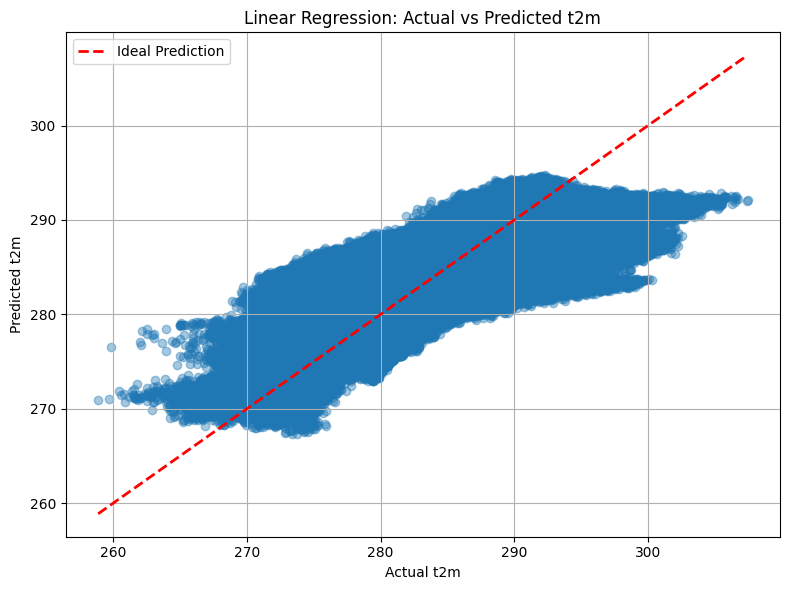

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_validation, y_validation_pred, alpha=0.4)
plt.plot([y_validation.min(), y_validation.max()],
         [y_validation.min(), y_validation.max()],
         color="red", linestyle="--", linewidth=2, label="Ideal Prediction")
plt.xlabel("Actual t2m")
plt.ylabel("Predicted t2m")
plt.title("Linear Regression: Actual vs Predicted t2m")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()